In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import copy

In [2]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [10]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, confidence_threshold):
	for person in keypoints_with_scores:
		y, x, c = frame.shape
		shaped = np.squeeze(np.multiply(person, [y,x,1]))
		# print(shaped)
		for i, kp in enumerate(shaped):
			if i == 5 or i == 6:
				ky, kx, kp_conf = kp
				if kp_conf > confidence_threshold:
					cv.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)
					cv.putText(frame, text=f"{i}", org=(int(kx), int(ky)),
							fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(0, 0, 0), thickness=1, lineType=cv.LINE_AA)

In [23]:
import copy
def GetHeadDict(img):
	Height, Width = img.shape[:2]
	# Width : Height = 400 : ?
	img = cv.resize(img, (400, int(400 * Height / Width)))
	Height, Width = img.shape[:2]

	temp = copy.deepcopy(img)
	temp = tf.image.resize_with_pad(tf.expand_dims(temp, axis=0), 384,640)
	temp = tf.cast(temp, dtype=tf.int32)
	# Detection section
	results = movenet(temp)
	keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

	ShowImage = copy.deepcopy(img)
	HeadDict = {}
	HeadDict['originalimg'] = img.copy()
	HeadList = []
	for person in keypoints_with_scores:
		y, x, c = ShowImage.shape

		shaped = np.squeeze(np.multiply(person, [y,x,1]))
		RightArmY, RightArmX = shaped[5,:2]
		LeftArmY, LeftArmX = shaped[6,:2]

		WidthHeight = int(abs(RightArmX - LeftArmX))
		HeadCenter = (int((RightArmX + LeftArmX) / 2), int((RightArmY + LeftArmY) / 2 - WidthHeight / 2))
		x0,y0,x1,y1=int(HeadCenter[0] - WidthHeight/2),int(HeadCenter[1] - WidthHeight/2),int(HeadCenter[0] + WidthHeight/2),int(HeadCenter[1] + WidthHeight/2)
		HeadImage = img[y0:y1,x0:x1]
		HeadImage = cv.resize(HeadImage, (100, 100))

		HeadList.append({
			"head" : HeadImage,
			"headpos" : (x0, y0, x1, y1),
			"bodypos" : (int(x0 - WidthHeight/3),y0,int(x1 + WidthHeight/3),int(y1 + WidthHeight * 3))
		})
	HeadDict['headlist'] = HeadList
	return HeadDict

In [11]:
OriginalImage = cv.imread('E:\GithubProjects\HelmetDetection\TestImage.jpg')

while True:
	ShowImage = copy.deepcopy(OriginalImage)
	Height, Width = ShowImage.shape[:2]
	# Width : Height = 400 : ?
	ShowImage = cv.resize(ShowImage, (400, int(400 * Height / Width)))
	Height, Width = ShowImage.shape[:2]

	img = ShowImage.copy()
	img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
	input_img = tf.cast(img, dtype=tf.int32)

	# Detection section
	results = movenet(input_img)
	keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

	# Render keypoints 
	loop_through_people(ShowImage, keypoints_with_scores, 0.1)

	cv.imshow('Movenet Multipose', ShowImage)

	if cv.waitKey(1) == ord('q'):
		break
cv.destroyAllWindows()

[[1.11744215e+02 1.89891469e+02 3.81948501e-01]
 [1.10182846e+02 1.90826023e+02 4.62308228e-01]
 [1.09841817e+02 1.88393819e+02 5.64123154e-01]
 [1.11387854e+02 1.92263246e+02 4.78438407e-01]
 [1.11108008e+02 1.86603487e+02 2.69021422e-01]
 [1.18841457e+02 1.94307923e+02 6.50278211e-01]
 [1.18634813e+02 1.84070396e+02 1.62092492e-01]
 [1.29667314e+02 1.99696064e+02 2.59025007e-01]
 [1.30370912e+02 1.84429777e+02 1.11291237e-01]
 [1.35060590e+02 1.95301557e+02 1.99287951e-01]
 [1.36496055e+02 1.85278189e+02 1.74348533e-01]
 [1.37656518e+02 1.91810036e+02 5.75635791e-01]
 [1.37210854e+02 1.86936033e+02 4.75776494e-01]
 [1.51774884e+02 1.91386640e+02 2.62040287e-01]
 [1.52029719e+02 1.87704504e+02 2.60930687e-01]
 [1.62808169e+02 1.93222845e+02 2.22012609e-01]
 [1.64777894e+02 1.93104863e+02 2.53708988e-01]]
[[8.51018205e+01 2.27778840e+02 2.70641714e-01]
 [7.40312213e+01 2.32136273e+02 1.15974933e-01]
 [7.58186637e+01 2.25360870e+02 4.45040286e-01]
 [6.61461003e+01 2.58411002e+02 2.67937

In [24]:
OriginalImage = cv.imread('E:\GithubProjects\HelmetDetection\TestImage.jpg')
MyHeadDict = GetHeadDict(OriginalImage)

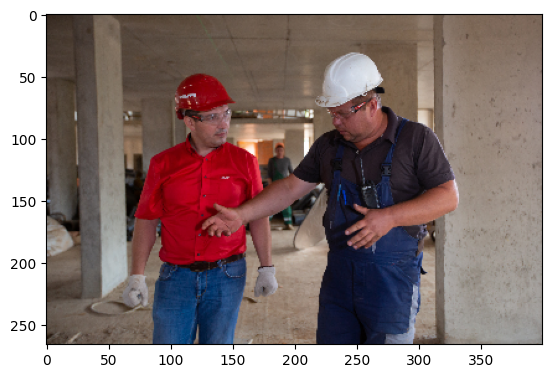

In [28]:
plt.imshow(MyHeadDict['originalimg'][:,:,::-1])

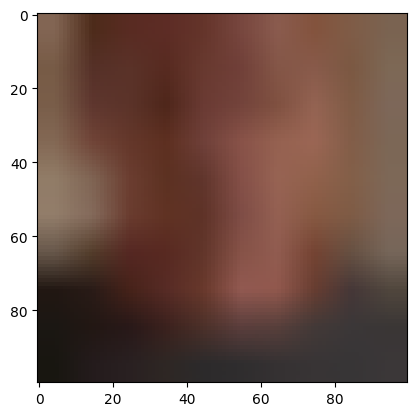

In [30]:
plt.imshow(MyHeadDict['headlist'][0]['head'][:,:,::-1])

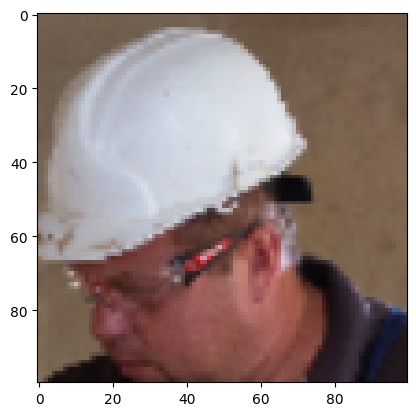

In [31]:
plt.imshow(MyHeadDict['headlist'][1]['head'][:,:,::-1])

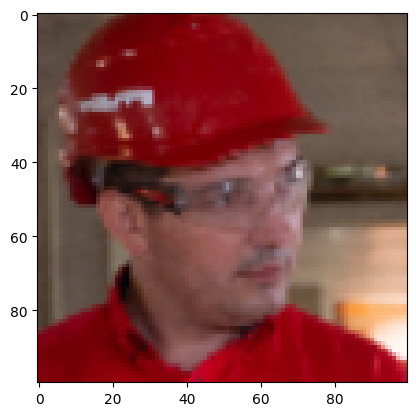

In [32]:
plt.imshow(MyHeadDict['headlist'][2]['head'][:,:,::-1])